# Stable Diffusion Assignment
The assignment implements two parts:


1.   Text to img SD model for SD Panorama + Seam Tiling: A stable diffusion model is used for generating panoramas from a given input text prompt. Seam tiling was tried using two ways. Firstly, a panorama stitching approach using keypoint matching was tried but did not work well due to inability to match the keypoints in the edges. The second approach used another SD model for inpainting to remove the inconsistency in the edges.
2.   Depth map for conditioning of Panorama: A ControlNet model is used for conditioning generation in the prior step via a depth map. The generated image is also similarly seam tiled to ensure continuity.



##Setup
All libraries required to be installed

In [1]:
!pip install diffusers transformers accelerate safetensors huggingface_hub peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# Required for SDXL Panorama
!git clone https://github.com/replicate/cog-sdxl cog_sdxl

Cloning into 'cog_sdxl'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 572 (delta 238), reused 220 (delta 177), pack-reused 267
Receiving objects: 100% (572/572), 20.23 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (331/331), done.


## Part 1: Generation of 360 panorama and Seam Tiling

In [3]:
import torch
from huggingface_hub import hf_hub_download
from diffusers import DiffusionPipeline
from cog_sdxl.dataset_and_utils import TokenEmbeddingsHandler
from diffusers.models import AutoencoderKL
import cv2
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
#Create diffusion model
pipe = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16,
        variant="fp16",
).to("cuda")

pipe.load_lora_weights("jbilcke-hf/sdxl-panorama", weight_name="lora.safetensors")

text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

embedding_path = hf_hub_download(repo_id="jbilcke-hf/sdxl-panorama", filename="embeddings.pti", repo_type="model")
embhandler = TokenEmbeddingsHandler(text_encoders, tokenizers)
embhandler.load_embeddings(embedding_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

lora.safetensors:   0%|          | 0.00/186M [00:00<?, ?B/s]

embeddings.pti:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

In [9]:
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a barn in a field"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a futurustic space station with outer space visible through a window"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a cozy log cabin in the woods"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a modern house"
prompt="hdri view, equirectangular panorama 360 panoramic picture of a house on the beach with the ocean and sands visible through the window"

images = pipe(
    prompt,
    cross_attention_kwargs={"scale": 0.8},
    height=512,
    width=1024,
    num_inference_steps=50,
).images

#your output image
panorama_output = images[0]
panorama_output.save("pano_output.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
panorama_img = Image.open("pano_output.png")
panorama_cv2 = cv2.cvtColor(np.array(panorama_img), cv2.COLOR_RGB2BGR)

panorama_cv2_left = panorama_cv2[:, 512:]
panorama_cv2_right = panorama_cv2[:, :512]

panorama_cv2_left.shape, panorama_cv2_right.shape

((512, 512, 3), (512, 512, 3))

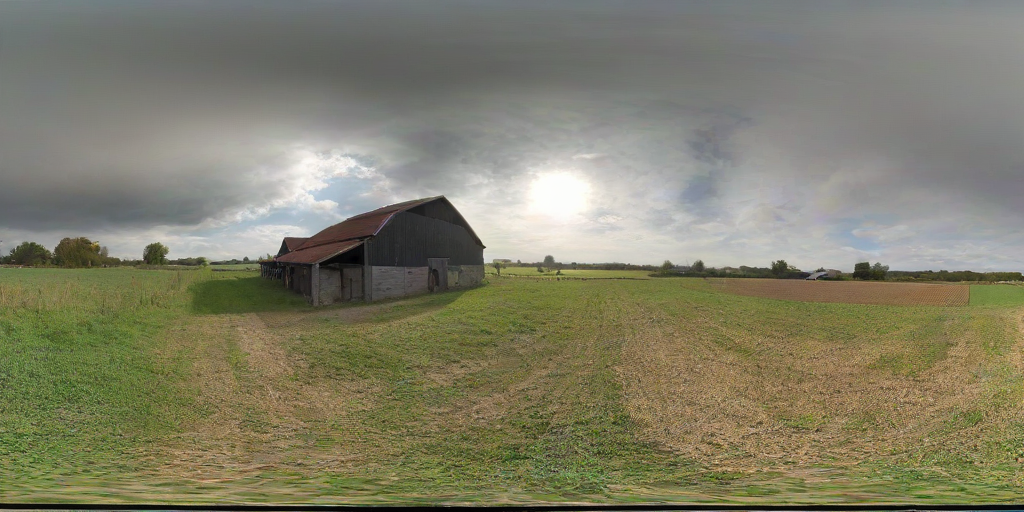

In [ ]:
cv2_imshow(panorama_cv2)

array([[[122, 117, 111],
        [121, 116, 110],
        [121, 117, 112],
        ...,
        [141, 138, 132],
        [142, 138, 134],
        [142, 139, 134]],

       [[122, 117, 112],
        [121, 118, 113],
        [122, 118, 113],
        ...,
        [141, 139, 134],
        [141, 139, 135],
        [142, 139, 135]],

       [[122, 118, 112],
        [122, 118, 113],
        [122, 118, 113],
        ...,
        [142, 139, 135],
        [142, 139, 135],
        [142, 139, 135]],

       ...,

       [[  6,   6,   7],
        [  5,   6,   7],
        [  6,   8,   7],
        ...,
        [ 19,  14,   7],
        [ 19,  13,   8],
        [ 25,  13,   5]],

       [[  4,   4,   6],
        [  6,   6,   7],
        [  6,   7,   7],
        ...,
        [118, 106,  66],
        [111, 100,  64],
        [127, 110,  70]],

       [[ 15,  17,  20],
        [  8,   6,   9],
        [ 10,   7,   9],
        ...,
        [114,  85,  43],
        [121,  89,  50],
        [104,  75,  34]]], dtype=uint8)
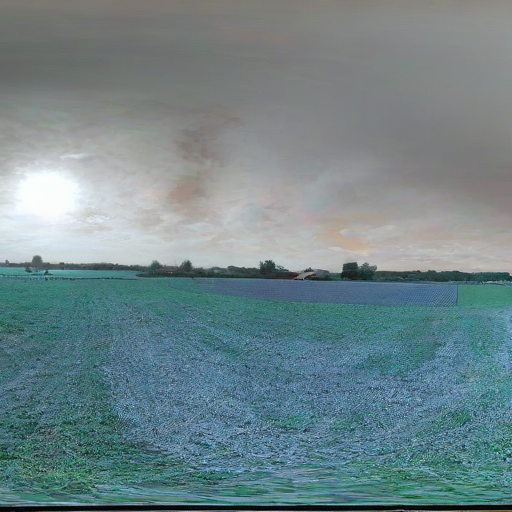

In [ ]:
panorama_cv2_left

array([[[134, 135, 126],
        [135, 136, 125],
        [135, 136, 126],
        ...,
        [123, 118, 111],
        [123, 118, 112],
        [123, 119, 113]],

       [[130, 130, 120],
        [129, 129, 120],
        [127, 127, 119],
        ...,
        [124, 119, 112],
        [124, 119, 113],
        [123, 118, 112]],

       [[128, 128, 119],
        [129, 129, 120],
        [128, 128, 118],
        ...,
        [122, 118, 112],
        [122, 118, 112],
        [122, 118, 112]],

       ...,

       [[121, 147, 155],
        [119, 145, 151],
        [116, 138, 143],
        ...,
        [  5,   6,   6],
        [  6,   6,   7],
        [  6,   7,   8]],

       [[130, 155, 166],
        [120, 143, 152],
        [126, 149, 157],
        ...,
        [  7,   8,   9],
        [  9,   8,   9],
        [  6,   6,   7]],

       [[129, 155, 162],
        [136, 158, 164],
        [123, 148, 154],
        ...,
        [ 12,  11,  14],
        [ 14,  14,  16],
        [ 17,  18,  20]]], dtype=uint8)
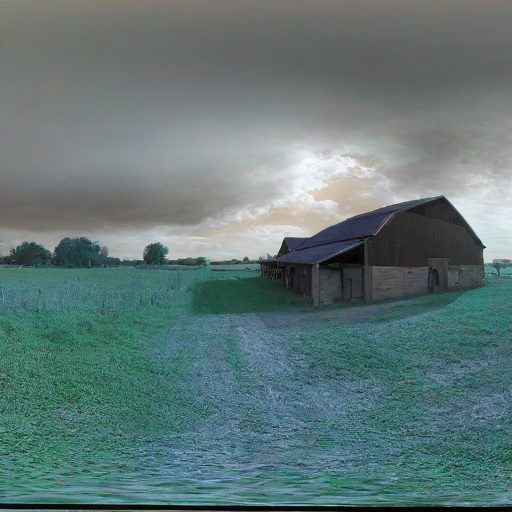

In [ ]:
panorama_cv2_right

In [ ]:
#Attempting stitching
stitcher = cv2.Stitcher_create()
(status, stitched) = stitcher.stitch([panorama_cv2_left, panorama_cv2_right])

status

1

In [ ]:
cv2_imshow(stitched)

AttributeError: 'NoneType' object has no attribute 'clip'

Stitching does not work due to inavalibaility of sufficient keypoint matches

In [3]:
#Using Inpainting from SD
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch
from PIL import Image
import cv2
import numpy as np

pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16").to("cuda")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:25: FutureWarning: `VQModel` is deprecated and will be removed in version 0.31. Importing `VQModel` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQModel`, instead.
  deprecate("VQModel", "0.31", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the H

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [3]:
from huggingface_hub import hf_hub_download
from cog_sdxl.dataset_and_utils import TokenEmbeddingsHandler

pipe.load_lora_weights("jbilcke-hf/sdxl-panorama", weight_name="lora.safetensors")

text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

embedding_path = hf_hub_download(repo_id="jbilcke-hf/sdxl-panorama", filename="embeddings.pti", repo_type="model")
embhandler = TokenEmbeddingsHandler(text_encoders, tokenizers)
embhandler.load_embeddings(embedding_path)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [34]:
panorama_img = Image.open("pano_output_ex5.png")
panorama_cv2 = cv2.cvtColor(np.array(panorama_img), cv2.COLOR_RGB2BGR)

panorama_cv2_left = panorama_cv2[:, 512:]
panorama_cv2_right = panorama_cv2[:, :512]

panorama_cv2_left.shape, panorama_cv2_right.shape

((512, 512, 3), (512, 512, 3))

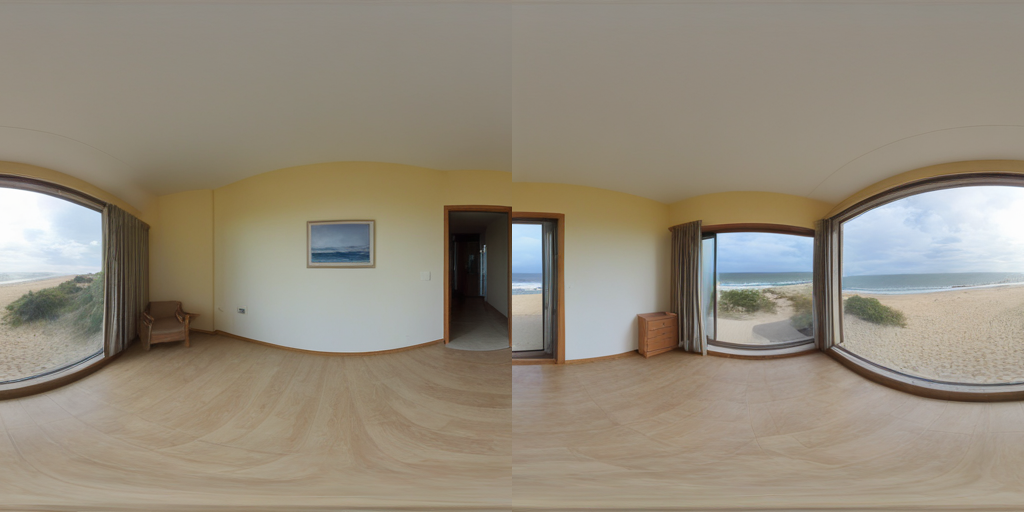

In [35]:
# Split in middle and attach opposite sides together
panorama_cv2_switched = np.concatenate((panorama_cv2_left, panorama_cv2_right), axis=1)
panorama_cv2_switched = cv2.cvtColor(panorama_cv2_switched, cv2.COLOR_BGR2RGB)
panorama_switched = Image.fromarray(panorama_cv2_switched)

panorama_switched

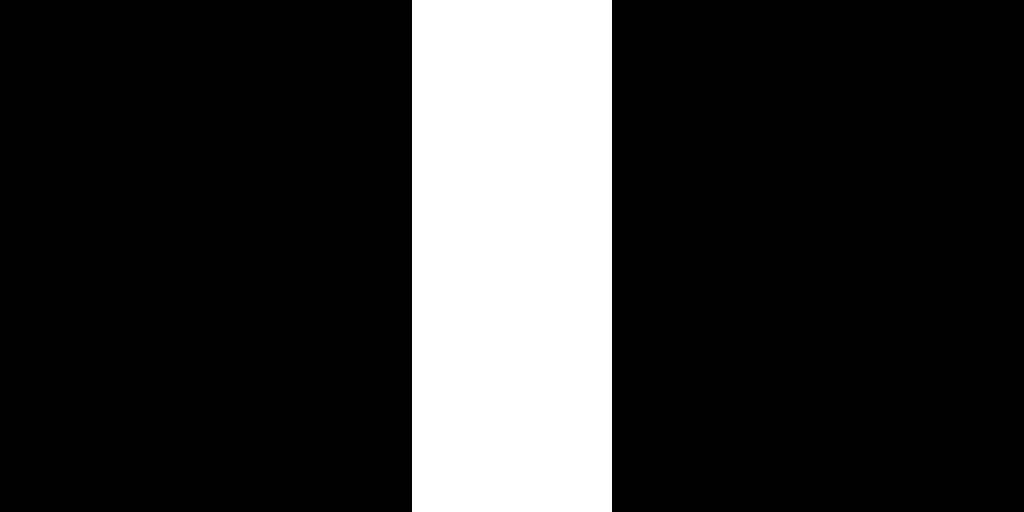

In [36]:
#Mask out middle 200 pixels for inpainting
mask = np.zeros(panorama_cv2_switched.shape, np.uint8)
mask[:, 412:612] = 255
mask = Image.fromarray(mask)

mask

In [37]:
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a barn in a field"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a futurustic space station with outer space visible through a window"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a cozy log cabin in the woods"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a modern house"
prompt="hdri view, equirectangular panorama 360 panoramic picture of a house on the beach with the ocean and sands visible through the window"

generator = torch.Generator(device="cuda").manual_seed(0)

In [38]:
seam_tiled_image = pipe(
  prompt=prompt,
  image=panorama_switched,
  mask_image=mask,
  guidance_scale=8.0,
  num_inference_steps=30,  # steps between 15 and 30 work well for us
  strength=0.99,  # make sure to use `strength` below 1.0,
  height=512,
  width=1024,
  generator=generator,
).images[0]

seam_tiled_image.save("pano_output_seam_tiled.png")

  0%|          | 0/29 [00:00<?, ?it/s]

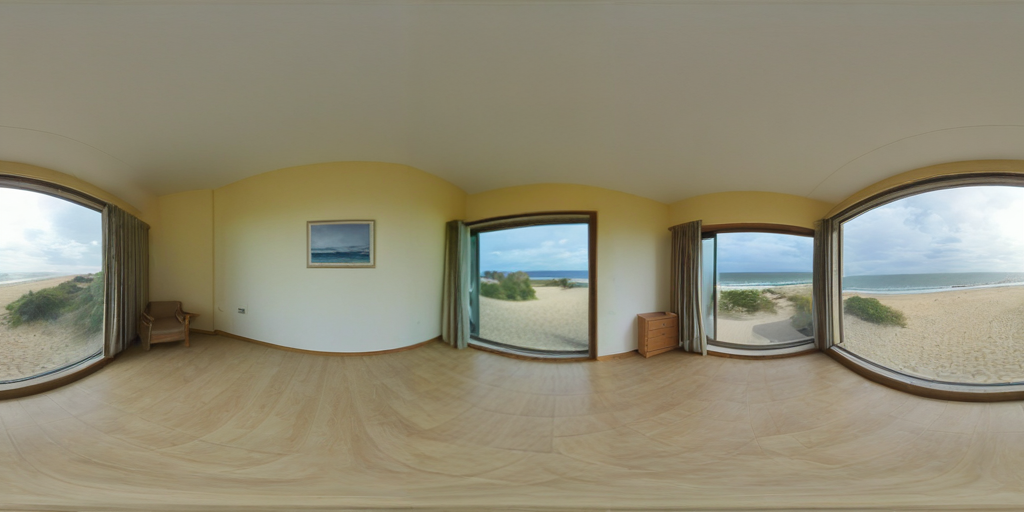

In [39]:
seam_tiled_image

##Part 2:  Depth Conditioning to improve generation

In [3]:
# !pip install opencv-python transformers accelerate
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch

from PIL import Image
import cv2
import numpy as np

# initialize the models and pipeline
controlnet_conditioning_scale = 0.5  # recommended for good generalization
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0", torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, vae=vae, torch_dtype=torch.float16
).to("cuda")
#pipe.enable_model_cpu_offload()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
from huggingface_hub import hf_hub_download
from cog_sdxl.dataset_and_utils import TokenEmbeddingsHandler

pipe.load_lora_weights("jbilcke-hf/sdxl-panorama", weight_name="lora.safetensors")

text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

embedding_path = hf_hub_download(repo_id="jbilcke-hf/sdxl-panorama", filename="embeddings.pti", repo_type="model")
embhandler = TokenEmbeddingsHandler(text_encoders, tokenizers)
embhandler.load_embeddings(embedding_path)

embeddings.pti:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

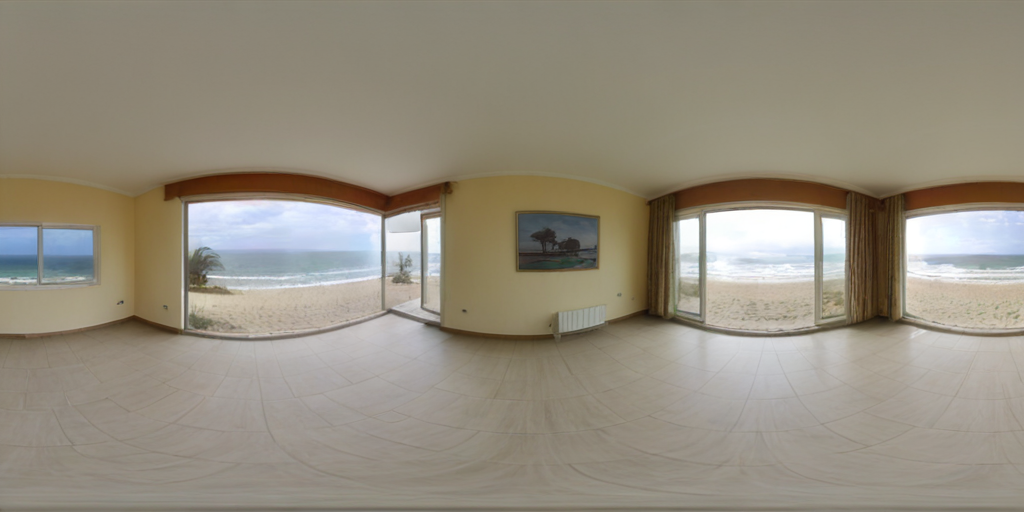

In [10]:
# load depth map image
depth_image = Image.open("pano_depth.png")

#prompt="hdri view, equirectangular panorama 360 panoramic picture of a barn in a field"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a futurustic space station with outer space visible through a window"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a cozy log cabin in the woods"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a modern house"
prompt="hdri view, equirectangular panorama 360 panoramic picture of a house on the beach with the ocean and sands visible through the window"
#negative_prompt = "low quality, bad quality, sketches"

# generate image
panorama_image = pipe(
    prompt,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    image=depth_image,
    height=512,
    width=1024).images[0]

panorama_image.save("pano_output_2.png")
panorama_image

In [3]:
#Using Inpainting from SD
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch
from PIL import Image
import cv2
import numpy as np

pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16").to("cuda")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:25: FutureWarning: `VQModel` is deprecated and will be removed in version 0.31. Importing `VQModel` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQModel`, instead.
  deprecate("VQModel", "0.31", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the H

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [4]:
from huggingface_hub import hf_hub_download
from cog_sdxl.dataset_and_utils import TokenEmbeddingsHandler

pipe.load_lora_weights("jbilcke-hf/sdxl-panorama", weight_name="lora.safetensors")

text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

embedding_path = hf_hub_download(repo_id="jbilcke-hf/sdxl-panorama", filename="embeddings.pti", repo_type="model")
embhandler = TokenEmbeddingsHandler(text_encoders, tokenizers)
embhandler.load_embeddings(embedding_path)

lora.safetensors:   0%|          | 0.00/186M [00:00<?, ?B/s]

embeddings.pti:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

In [35]:
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a barn in a field"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a futurustic space station with outer space visible through a window"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a cozy log cabin in the woods"
#prompt="hdri view, equirectangular panorama 360 panoramic picture of a modern house"
prompt="hdri view, equirectangular panorama 360 panoramic picture of a house on the beach with the ocean and sands visible through the window"
generator = torch.Generator(device="cuda").manual_seed(0)

In [36]:
panorama_img = Image.open("pano_output_2_ex5.png")
panorama_cv2 = cv2.cvtColor(np.array(panorama_img), cv2.COLOR_RGB2BGR)

panorama_cv2_left = panorama_cv2[:, 512:]
panorama_cv2_right = panorama_cv2[:, :512]

panorama_cv2_left.shape, panorama_cv2_right.shape

((512, 512, 3), (512, 512, 3))

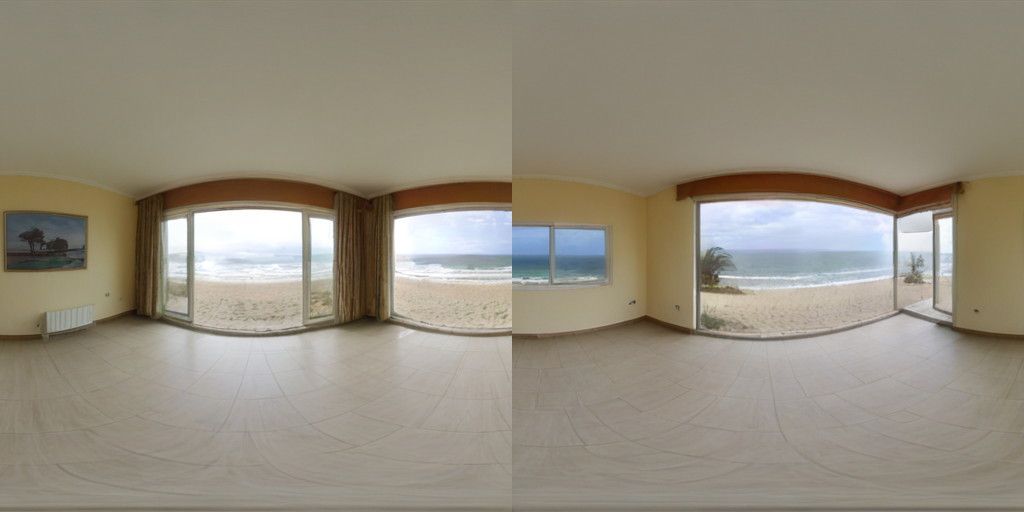

In [37]:
# Split in middle and attach opposite sides together
panorama_cv2_switched = np.concatenate((panorama_cv2_left, panorama_cv2_right), axis=1)
panorama_cv2_switched = cv2.cvtColor(panorama_cv2_switched, cv2.COLOR_BGR2RGB)
panorama_switched = Image.fromarray(panorama_cv2_switched)

panorama_switched

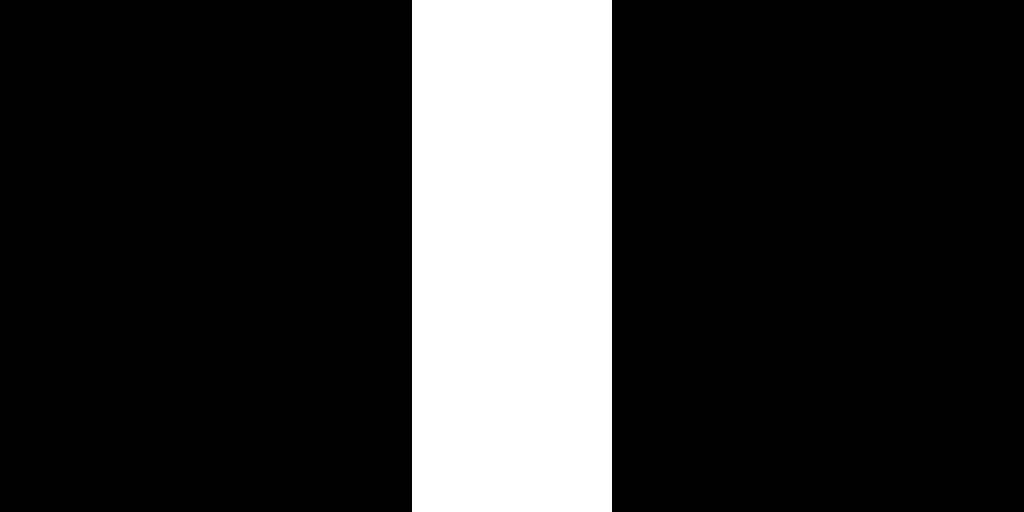

In [38]:
#Mask out middle 200 pixels for inpainting
mask = np.zeros(panorama_cv2_switched.shape, np.uint8)
mask[:, 412:612] = 255
mask = Image.fromarray(mask)

mask

In [39]:
seam_tiled_image = pipe(
  prompt=prompt,
  image=panorama_switched,
  mask_image=mask,
  guidance_scale=8.0,
  num_inference_steps=30,  # steps between 15 and 30 work well for us
  strength=0.99,  # make sure to use `strength` below 1.0,
  height=512,
  width=1024,
  generator=generator,
).images[0]

seam_tiled_image.save("pano_output_seam_tiled_2.png")

  0%|          | 0/29 [00:00<?, ?it/s]

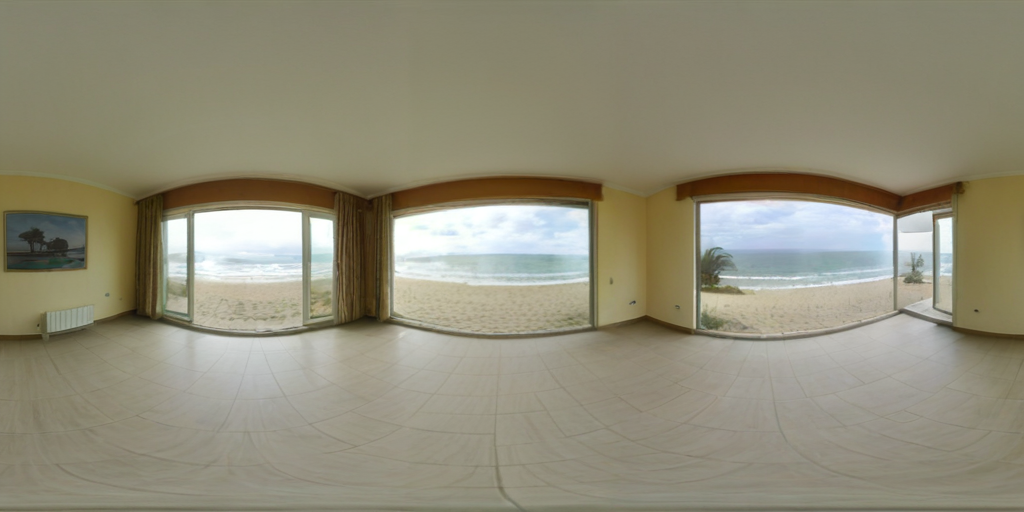

In [40]:
seam_tiled_image